In [1]:
%load_ext autoreload
%autoreload 2

# Multiprocessing tests

Trying out the parallel computation on GCP

In [2]:
from multiprocessing import Pool, cpu_count
import time

In [3]:
cpu_count()

64

In [4]:
def eval_fun(asdf):
    time.sleep(0.1)
    return asdf + 1

In [5]:
%%time
avec = []
for i in range(20):
    avec.append(eval_fun(i))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2 s


In [6]:
%%time
n_process = 10
if __name__ == '__main__':
    print('main')
    p = Pool(processes=n_process)

main
CPU times: user 16 ms, sys: 48 ms, total: 64 ms
Wall time: 57.5 ms


In [7]:
%%time
n_run = 20
p_result = p.map_async(eval_fun, range(n_run))
avec = p_result.get()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 203 ms


## Testing Tensorflow

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cProfile, pstats
import numpy as np
from timing import *

In [3]:
def build_model(s, N, a):
  model = keras.Sequential([
    layers.Dense(N, activation=tf.nn.tanh, input_shape=[s]),
    layers.Dense(a)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [4]:
s_size = 100
N_hid = 200
a_size = 50
k = 100
rand_input = np.random.rand(k,s_size)
rand_output = np.random.rand(k,a_size)

In [5]:
model = build_model(s_size, N_hid, a_size)
model.summary()

W0903 18:46:26.416109 140448619489024 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
Total params: 30,250
Trainable params: 30,250
Non-trainable params: 0
_________________________________________________________________


In [16]:
%%time
history = model.fit(rand_input, rand_output)

100/100 [==============================] - 0s 100us/sample - loss: 0.1411 - mean_absolute_error: 0.3074 - mean_squared_error: 0.1411
CPU times: user 552 ms, sys: 80 ms, total: 632 ms
Wall time: 14.6 ms


In [7]:
w_in = tf.Variable(tf.random_uniform([s_size,N_hid],0,0.01))
b_in = tf.Variable(tf.random_uniform([1,N_hid],0,0))
W = tf.Variable(tf.random_uniform([N_hid,a_size],0,0.01))

@tf.function
def _net_init(H_i,T_i):
    A_t1 = tf.add(tf.scalar_mul(1.0/gamma_r,tf.eye(N_hid)),tf.matmul(tf.transpose(H_i),H_i))
    A_t1_inv = tf.linalg.inv(A_t1)
    W_t1 = tf.matmul(A_t1_inv,tf.matmul(tf.transpose(H_i),T_i))
    return W_t1, A_t1_inv

@tf.function
def _net_update(H_i,T_i,W,A_inv):
    H_t = tf.transpose(H_i)
    K1 = tf.add(tf.matmul(H_i,tf.matmul(A_inv,H_t)),tf.eye(k))
    K_t = tf.subtract(tf.eye(N_hid),
        tf.matmul(A_inv,tf.matmul(H_t,tf.matmul(tf.linalg.inv(K1),H_i))))
    W_new = tf.add(tf.matmul(K_t,W),
        tf.matmul(tf.matmul(K_t,A_inv),tf.matmul(H_t,T_i)))
    A_new = tf.matmul(K_t,A_inv)
    return W_new, A_new

@tf.function
def _act_fn(X_i):
    return tf.tanh(tf.add(tf.matmul(X_i,w_in),b_in), name=None)

@tf.function
def _grad_update(X_i,T_i,W,w,b):
    act = tf.tanh(tf.add(tf.matmul(X_i,w),b), name=None)
    out = tf.matmul(act,W)
    loss = tf.reduce_sum(tf.square(T_i - out))
    trainer = tf.compat.v1.train.GradientDescentOptimizer(alpha)
    self.updateModel = trainer.minimize(loss,var_list=[W,w_in,b_in])

## Timing Artificial Examples

In [5]:
import cProfile, pstats
import numpy as np
from timing import *
from multiprocessing import Pool, cpu_count
from itertools import repeat, product
from tqdm import tqdm as p_bar
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [32]:
size_s = 500
size_a = 500
N_hid = 500
k = 20

# print('ELM')
# ps = None
# while ps is None:
#     try:
#         ps = t_elm(size_s, N_hid, size_a, k)
#     except tf.errors.InvalidArgumentError:
#         pass
# ps.print_stats(5)
# print('\nELM H')
# ps = t_elmH(size_s, N_hid, size_a, k)
# ps.print_stats(5)
# print('\nELM Basic')
# ps = t_elm_basic(size_s, N_hid, size_a, k)
# ps.print_stats(5)
# print('\nELM Basic H')
# ps = t_elm_basicH(size_s, N_hid, size_a, k)
# ps.print_stats(5)
print('\nQNet')
ps = t_qnet(size_s, N_hid, size_a, k)
ps.print_stats()


QNet
         299509 function calls (291509 primitive calls) in 3.677 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.018    0.000    3.437    0.003 /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:840(run)
     1000    0.094    0.000    3.419    0.003 /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1084(_run)
     1000    0.016    0.000    2.738    0.003 /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1310(_do_run)
     1000    0.004    0.000    2.714    0.003 /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1354(_do_call)
     1000    0.006    0.000    2.710    0.003 /usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1337(_run_fn)
      500    0.006    0.000    2.666    0.005 /home/jupyter/smart-ml/ELM-RL/timing.py:249(update)
     1000    0.005    0.000    2.629    0.003 /usr

In [ ]:
def ps_t_run(ps):
    return ps.stats[('/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py', 840, 'run')][3]

def t_all(size_s, N_hid, size_a, k):
    ps_elm = t_elm(size_s, N_hid, size_a, k)
    ps_elmh = t_elmH(size_s, N_hid, size_a, k)
    ps_elmb = t_elm_basic(size_s, N_hid, size_a, k)
    ps_elmbh = t_elm_basicH(size_s, N_hid, size_a, k)
    ps_qnet = t_qnet(size_s, N_hid, size_a, k)
    r_dict = {'s':size_s, 'N':N_hid, 'a':size_a, 'k':k,
             'elm':ps_t_run(ps_elm), 'elmh':ps_t_run(ps_elmh),
             'elmb':ps_t_run(ps_elmb), 'elmbh':ps_t_run(ps_elmbh),
             'qnet':ps_t_run(ps_qnet)}
    return r_dict
    
# s0 = 10
# a0 = 2
k0 = 20

s_vec = np.linspace(200, 500, 7, dtype=np.int32)
N_vec = np.linspace(50, 500, 10, dtype=np.int32)
a_vec = np.linspace(50, 500, 10, dtype=np.int32)
# k_vec = [10**n for n in range(1,6)]

# n_iter = len(s_vec)*len(N_vec)*len(a_vec)*len(k_vec)
n_iter = len(s_vec)*len(N_vec)*len(a_vec)
results = []
fname = 'results_20_9_k20_add'
for s, n, a, k in p_bar(product(s_vec, N_vec, a_vec, [k0]), total=n_iter):
#     print('s {}, n {}, a {}, k {}'.format(s,n,a,k))
    r_iter = None
    while r_iter is None:
        try:
            r_iter = t_all(s, n, a, k)
        except tf.errors.InvalidArgumentError:
#             print('err')
            pass
    results.append(r_iter)
    pickle.dump(results,open(fname,'wb'))


 14%|█▍        | 98/700 [23:37:48<182:38:51, 1092.24s/it]

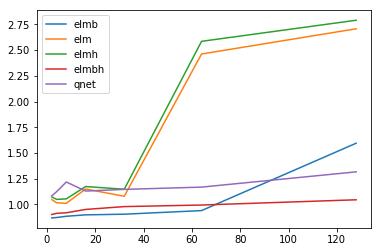

In [13]:
t_vec = {'elm':[], 'elmh':[], 'elmb':[], 'elmbh':[], 'qnet':[]}
for r in results:
    for key in t_vec.keys():
        t_vec[key].append(ps_t_run(r[key]))
        
fig = plt.figure()
for key in t_vec.keys():
    plt.plot(N_vec, t_vec[key], label=key)
plt.legend()

## Load + Process results

In [8]:
fname1 = 'results_19_9_k20'
fname2 = 'results_20_9_k20_add'
results1=pickle.load(open(fname1,'rb'))
results2=pickle.load(open(fname2,'rb'))
print(np.shape(results1))
print(np.shape(results2))

(367,)
(207,)


In [9]:
results=[]
results.extend(results1[:-67])
results.extend(results2[:-7])
np.shape(results)

(500,)

In [10]:
s_ind = np.linspace(50,250,5)
N_ind = np.linspace(50,500,10)
a_ind = np.linspace(50,500,10)
inds = pd.MultiIndex.from_product([s_ind, N_ind, a_ind], names=['s_size', 'N_hid', 'a_size'])
len(inds)

500

In [11]:
result_data = {'elm':[], 'elmb':[], 'elmh':[], 'elmbh':[], 'qnet':[]}
for r in results:
    for key in result_data.keys():
        result_data[key].append(r[key])

In [12]:
time_df = pd.DataFrame(result_data, index=inds)
time_df.head()

elm      elmb     elmbh      elmh      qnet
s_size N_hid a_size                                                  
50.0   50.0  50.0    0.583336  0.442017  0.467156  0.564586  0.636085
             100.0   1.153465  0.453029  0.470582  1.297722  0.703870
             150.0   1.114662  0.894384  0.990137  1.088775  1.268075
             200.0   1.159344  0.863434  0.976180  1.132030  1.265425
             250.0   1.227265  0.980229  1.167428  1.421974  1.486399

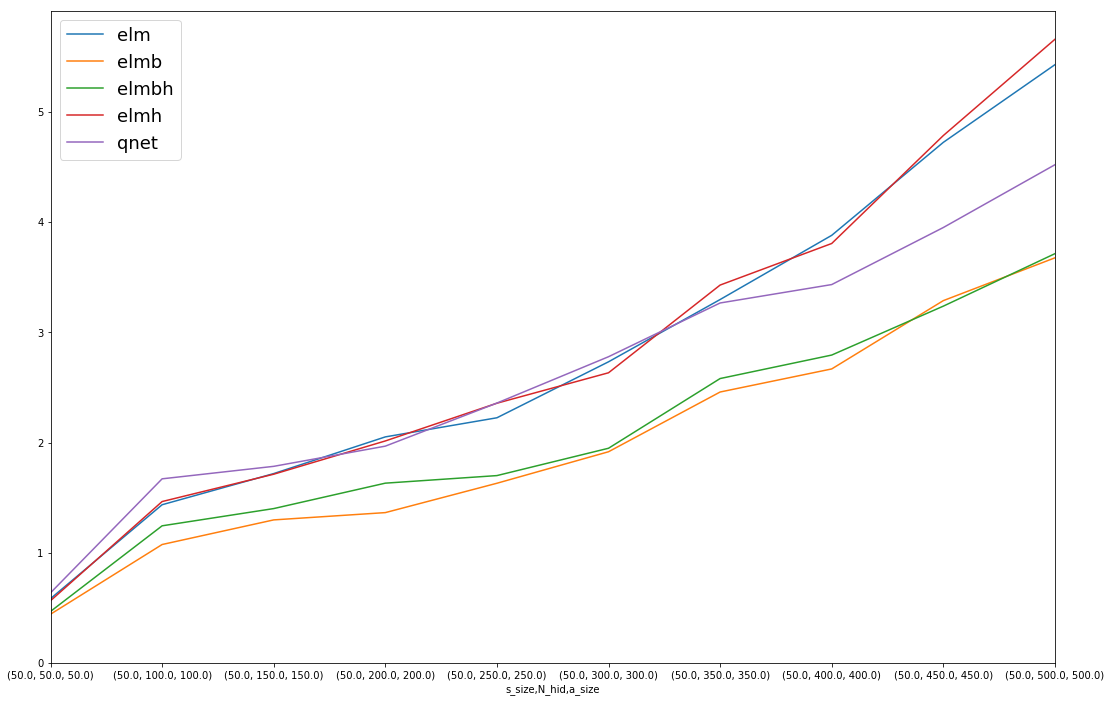

In [34]:
s_50_ind = [(50, i, i) for i in N_ind]
fig = plt.figure(figsize=(18,12))
ax = plt.gca()
ax = time_df.loc[s_50_ind,:].plot(ax=ax)
plt.legend(fontsize=18)
plt.ylim([0,None])
plt.savefig('time_trend.png', bbox_inches='tight')

(0, 24.7980075)

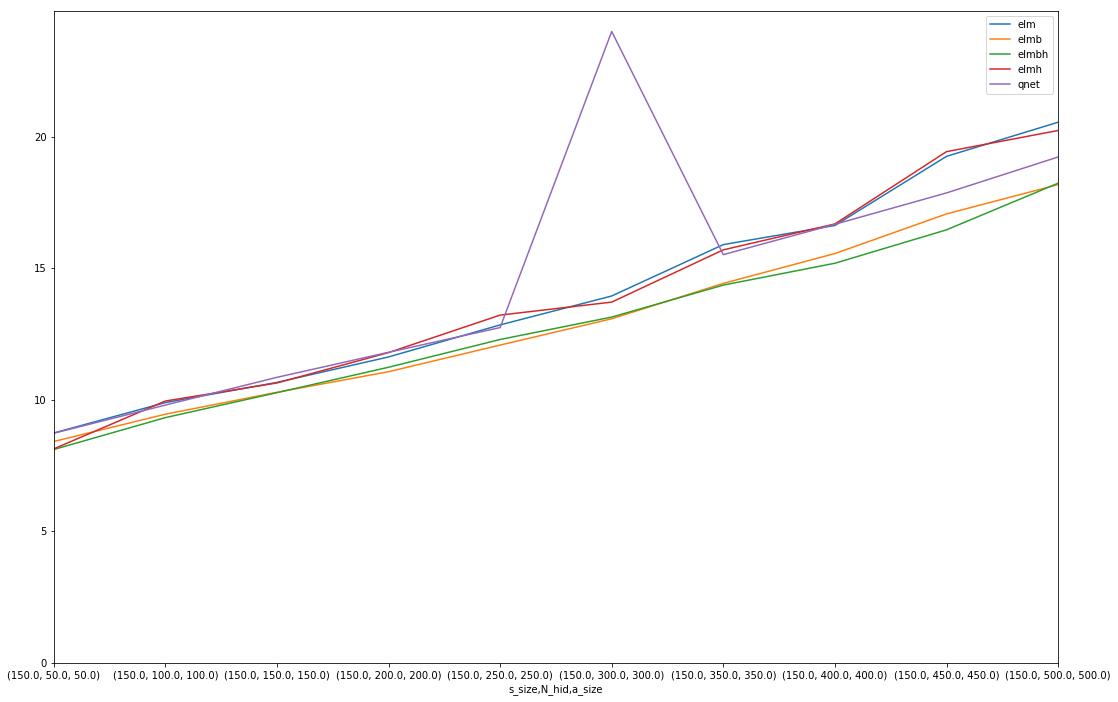

In [21]:
ns = 150
s_ns_ind = [(ns, i, i) for i in N_ind]
fig = plt.figure(figsize=(18,12))
ax = plt.gca()
ax = time_df.loc[s_ns_ind,:].plot(ax=ax)
plt.ylim([0,None])

(0, 71.64726945)

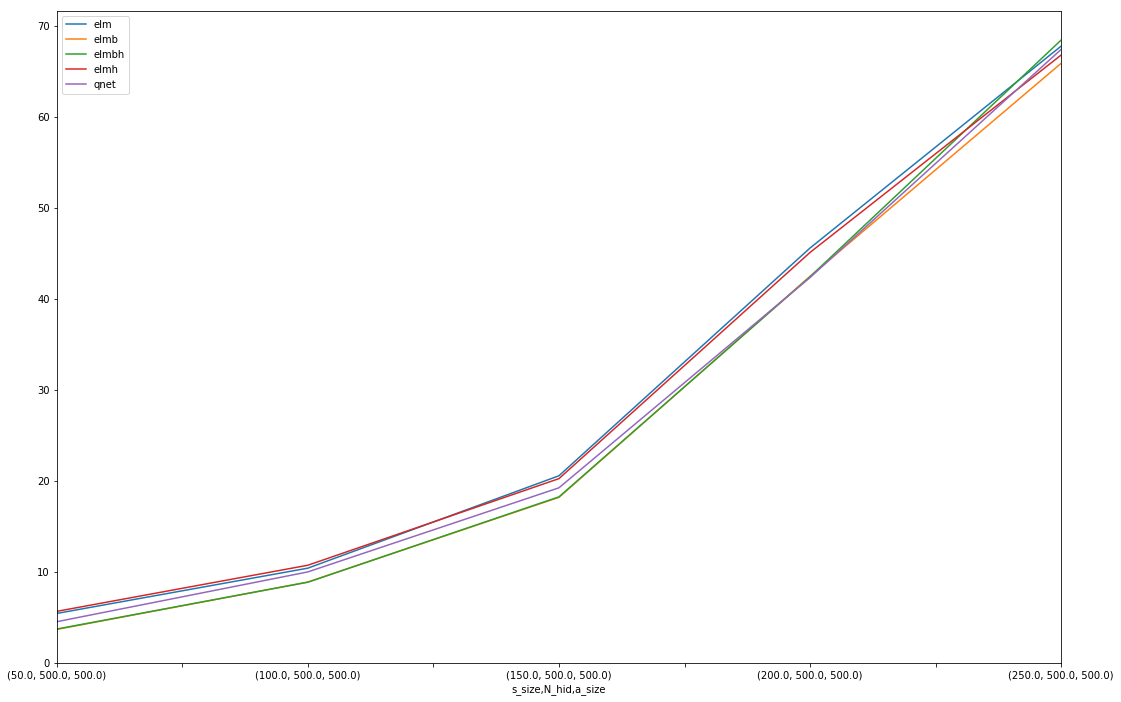

In [24]:
s_ns_ind = [(i, 500, 500) for i in s_ind]
fig = plt.figure(figsize=(18,12))
ax = plt.gca()
ax = time_df.loc[s_ns_ind,:].plot(ax=ax)
plt.ylim([0,None])